In [82]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [116]:
# Training Parameters
learning_rate = 0.001
num_steps = 500
batch_size = 128
display_step = 100

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
X = tf.placeholder(tf.float32, [None, 28, 28], name='InputData')
Y = tf.placeholder(tf.float32, [None, num_classes], name='LabelData')
keep_prob = tf.placeholder(tf.float32 , name='keep_prob') # dropout (keep probability)

In [100]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1, _padding='SAME'):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=_padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2, _padding='SAME'):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1]
                          , strides=[1, k, k, 1]
                          , padding=_padding)

# Create model
def conv_net(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    padding='SAME'
    k = 2
    strides = 1
#     with tf.name_scope('conv_layer_1'):
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
    print ("x shape is: " + str(x.shape))

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'], strides, padding)
    print ("after 1 layer of convolution, padding={}, strides={}: ".format(padding, strides) + str([5, 5, 1, 32]))
    print ("conv1 shape is: " + str(conv1.shape))

    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k, padding)
    print ("after 1 layer of maxpool layer: " + str([1, k, k, 1]))
    print ("conv1 shape is: " + str(conv1.shape))

#     with tf.name_scope('conv_layer_2'):
    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'], strides, padding)
    print ("after 2 layer of convolution, padding={}, strides={}: ".format(padding, strides) + str([5, 5, 32, 64]))
    print ("conv2 shape is: " + str(conv2.shape))

    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k, padding)
    print ("after 2 layer of maxpool layer: " + str([1, k, k, 1]))
    print ("conv2 shape is: " + str(conv2.shape))
    
    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
#     with tf.name_scope('fully_conn_layer'):
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    print ("Reshape conv2 output to fit fully connected layer input: " + "from " + str(conv2.shape) + " to " + str(fc1.shape))
    print ("weights['wd1'].get_shape().as_list()[0]: " + str(7*7*64))
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)
    print ("after dropout: " + str(fc1.shape))
    
#     with tf.name_scope('output_layer'):
        # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    print ("------")
    print ([1024, 10])
    print (" Output is: " + str(out.shape))
    return out

In [110]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input(grayscale 1 layer), 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32]), name='Conv_Weights_1'),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64]), name='Conv_Weights_2'),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024]), name='Full_con_Weights'),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]), name='Output_Weight')
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32]), name='Conv_Bias_1'),
    'bc2': tf.Variable(tf.random_normal([64]), name='Conv_Bias_2'),
    'bd1': tf.Variable(tf.random_normal([1024]), name='Full_con_Bias'),
    'out': tf.Variable(tf.random_normal([num_classes]), name='Output_Bias')
}

# Construct model
# with tf.name_scope('Model'):
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# with tf.name_scope('Loss'):
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
    
    
# with tf.name_scope('Accuracy'):
# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))    


# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

x shape is: (?, 28, 28, 1)
after 1 layer of convolution, padding=SAME, strides=1: [5, 5, 1, 32]
conv1 shape is: (?, 28, 28, 32)
after 1 layer of maxpool layer: [1, 2, 2, 1]
conv1 shape is: (?, 14, 14, 32)
after 2 layer of convolution, padding=SAME, strides=1: [5, 5, 32, 64]
conv2 shape is: (?, 14, 14, 64)
after 2 layer of maxpool layer: [1, 2, 2, 1]
conv2 shape is: (?, 7, 7, 64)
Reshape conv2 output to fit fully connected layer input: from (?, 7, 7, 64) to (?, 3136)
weights['wd1'].get_shape().as_list()[0]: 3136
after dropout: (?, 1024)
------
[1024, 10]
 Output is: (?, 10)


In [111]:
# Create a summary to monitor cost tensor
tf.summary.scalar("loss", loss_op)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("accuracy", accuracy)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()   


# python -m tensorboard.main --logdir=logs

In [121]:
# Start training
logs_path = '/tmp/tensorflow_logs'

with tf.Session() as sess:

    # Run the initializer
    sess.run(init)
    
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    for step in range(1, num_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        print (batch_x.shape, batch_y.shape)
        batch_x = batch_x.reshape(128, 28, 28)
        batch_x = batch_x.astype(np.float32)
        batch_y = batch_y.astype(np.float32)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc, summary = sess.run([loss_op, accuracy, merged_summary_op], feed_dict={keep_prob: 1., 
                                                                                             X: batch_x, 
                                                                                             Y: batch_y })
            summary_writer.add_summary(summary, step)
            
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))
            

    print("Optimization Finished!")
    
    
    print (mnist.test.images[:256].shape, mnist.test.labels[:256].shape)
    # Calculate accuracy for 256 MNIST test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: mnist.test.images[:256],
                                      Y: mnist.test.labels[:256],
                                      keep_prob: 1.}))

(128, 784) (128, 10)


InvalidArgumentError: You must feed a value for placeholder tensor 'LabelData_3' with dtype float and shape [?,10]
	 [[Node: LabelData_3 = Placeholder[dtype=DT_FLOAT, shape=[?,10], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'LabelData_3', defined at:
  File "D:\Anaconda_36\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Anaconda_36\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-109-961eca28a1c8>", line 14, in <module>
    Y = tf.placeholder(tf.float32, [None, num_classes], name='LabelData')
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1599, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3090, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "D:\Anaconda_36\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'LabelData_3' with dtype float and shape [?,10]
	 [[Node: LabelData_3 = Placeholder[dtype=DT_FLOAT, shape=[?,10], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


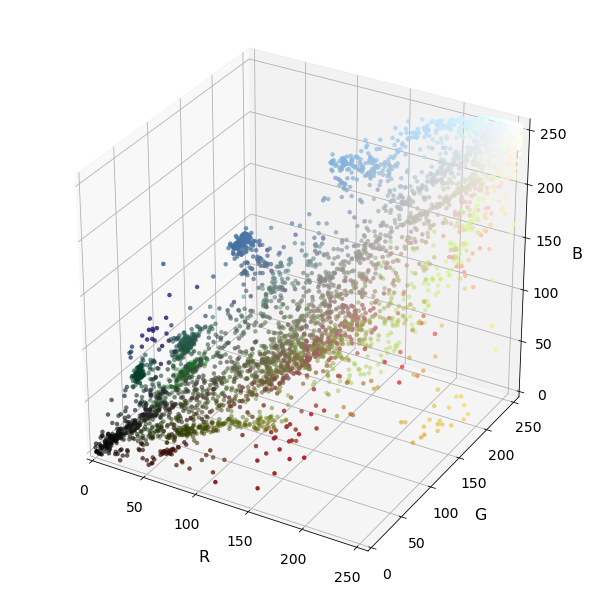

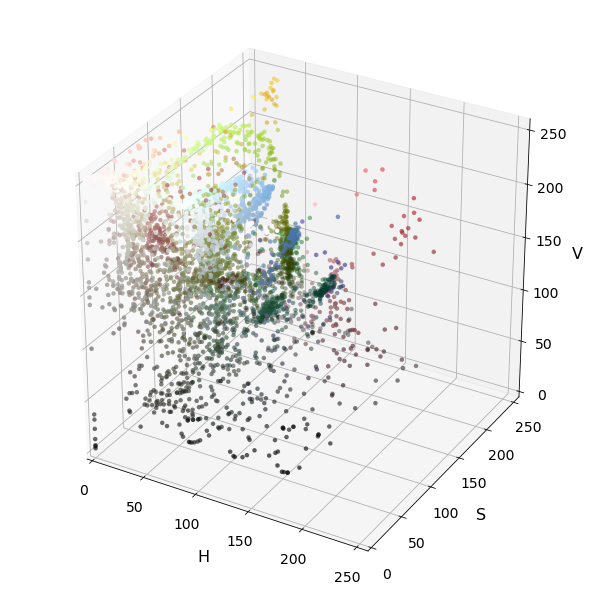

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = cv2.imread("img//mixed5a_9_examples.jpg")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()